In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv.gz")
df['date_time'] = pd.to_datetime(df['date_time'])

# Time features
df['hour_sin'] = np.sin(2*np.pi*df['date_time'].dt.hour/24)
df['hour_cos'] = np.cos(2*np.pi*df['date_time'].dt.hour/24)
df['day_sin'] = np.sin(2*np.pi*df['date_time'].dt.dayofweek/7)
df['day_cos'] = np.cos(2*np.pi*df['date_time'].dt.dayofweek/7)
df['is_holiday'] = df['holiday'].notna().astype(int)

# Select features & target
features = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 
               'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_holiday']]
target = df['traffic_volume'].values

# Time-based split
train_mask = df['date_time'].dt.year <= 2015
val_mask = df['date_time'].dt.year == 2016
test_mask = df['date_time'].dt.year >= 2017

X_train, y_train = features[train_mask], target[train_mask]
X_val, y_val = features[val_mask], target[val_mask]
X_test, y_test = features[test_mask], target[test_mask]

# Scale
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors (smaller subsets for performance)
SUBSET = 1000
X_train_tensor = torch.FloatTensor(X_train_scaled[:SUBSET])
y_train_tensor = torch.FloatTensor(y_train_scaled[:SUBSET])
X_val_tensor = torch.FloatTensor(X_val_scaled[:SUBSET//2])
y_val_tensor = torch.FloatTensor(y_val_scaled[:SUBSET//2])
X_test_tensor = torch.FloatTensor(X_test_scaled[:SUBSET//2])
y_test_tensor = torch.FloatTensor(y_test_scaled[:SUBSET//2])

In [3]:
# Define GP model class
class TrafficGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Kernel candidates
kernel_candidates = {
    "RBF": gpytorch.kernels.RBFKernel(),
    "Linear" : gpytorch.kernels.LinearKernel(),
    "Matern": gpytorch.kernels.MaternKernel(nu=2.5),  # smoothness parameter nu=2.5 is common default,,
    "Periodic": gpytorch.kernels.PeriodicKernel(),
}

results = {}

for name, kernel in kernel_candidates.items():
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.Interval(1e-4, 0.1)
    )
    model = TrafficGPModel(X_train_tensor, y_train_tensor, likelihood, kernel)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(100):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Validation evaluation
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_val = likelihood(model(X_val_tensor))
        mean = pred_val.mean.numpy()
        rmse = np.sqrt(np.mean((y_scaler.inverse_transform(mean.reshape(-1, 1)).flatten() -
                                y_scaler.inverse_transform(y_val_tensor.numpy().reshape(-1, 1)).flatten()) ** 2))
        model.train()
        likelihood.train()
        log_likelihood = mll(model(X_train_tensor), y_train_tensor).item()
        model.eval()
        likelihood.eval()

        
        results[name] = {
            "model": model,
            "likelihood": likelihood,
            "rmse": rmse,
            "log_likelihood": log_likelihood,
        }
        print(f"{name} -> Validation RMSE: {rmse:.2f}, Log Likelihood: {log_likelihood:.2f}")

# Select best model
best_kernel = min(results, key=lambda k: results[k]["rmse"])
best_model = results[best_kernel]["model"]
best_likelihood = results[best_kernel]["likelihood"]

RBF -> Validation RMSE: 983.93, Log Likelihood: 0.60
Linear -> Validation RMSE: 1371.91, Log Likelihood: 0.44
Matern -> Validation RMSE: 992.31, Log Likelihood: 0.51
Periodic -> Validation RMSE: 1189.70, Log Likelihood: 0.07



Kernel: RBF
Test RMSE: 921.66


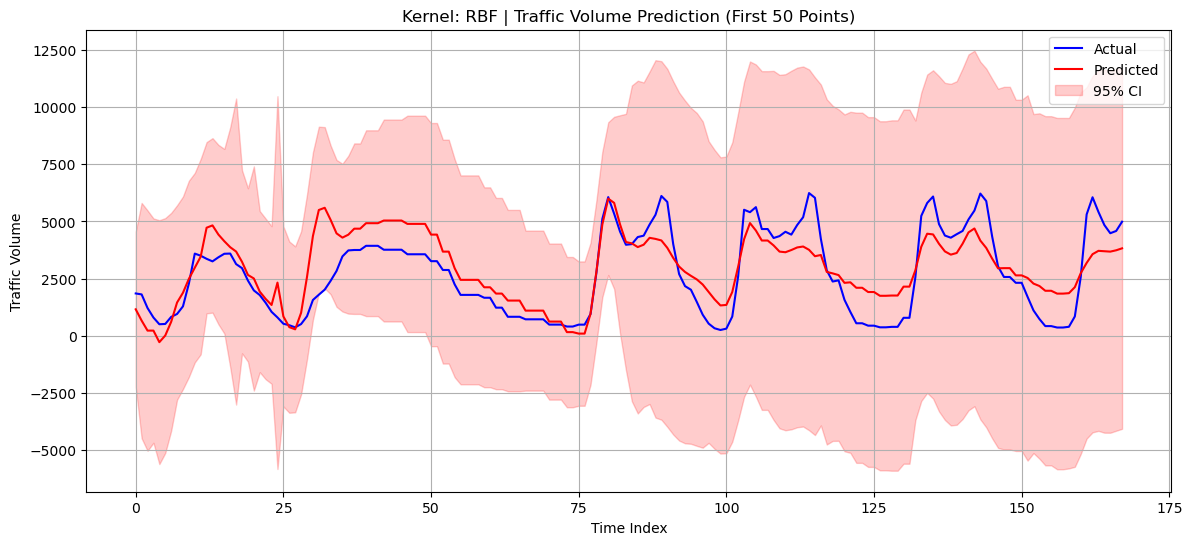


Kernel: Linear
Test RMSE: 1432.51


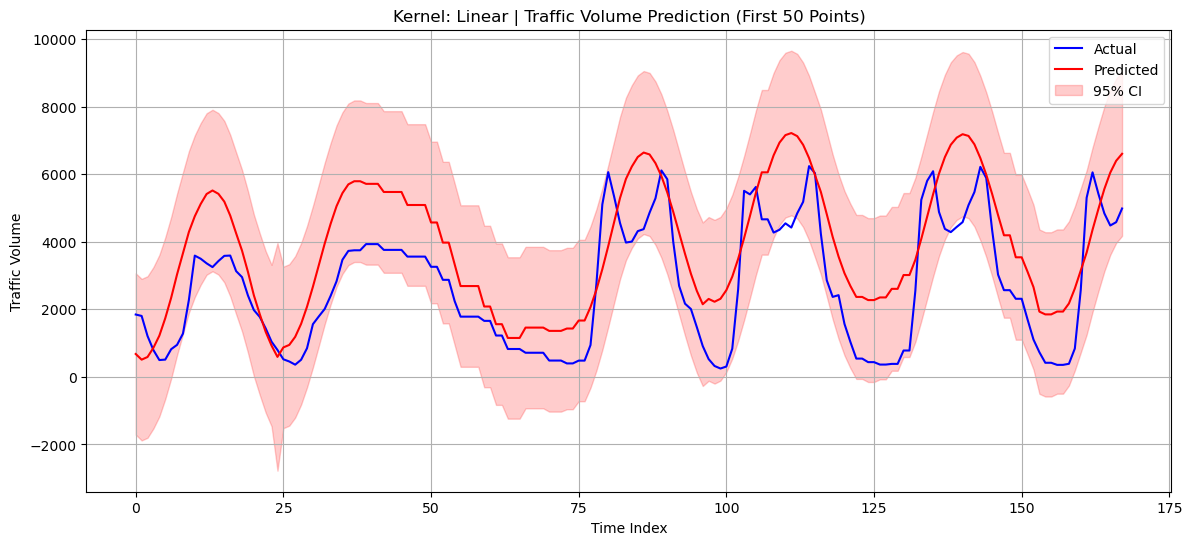


Kernel: Matern
Test RMSE: 930.42


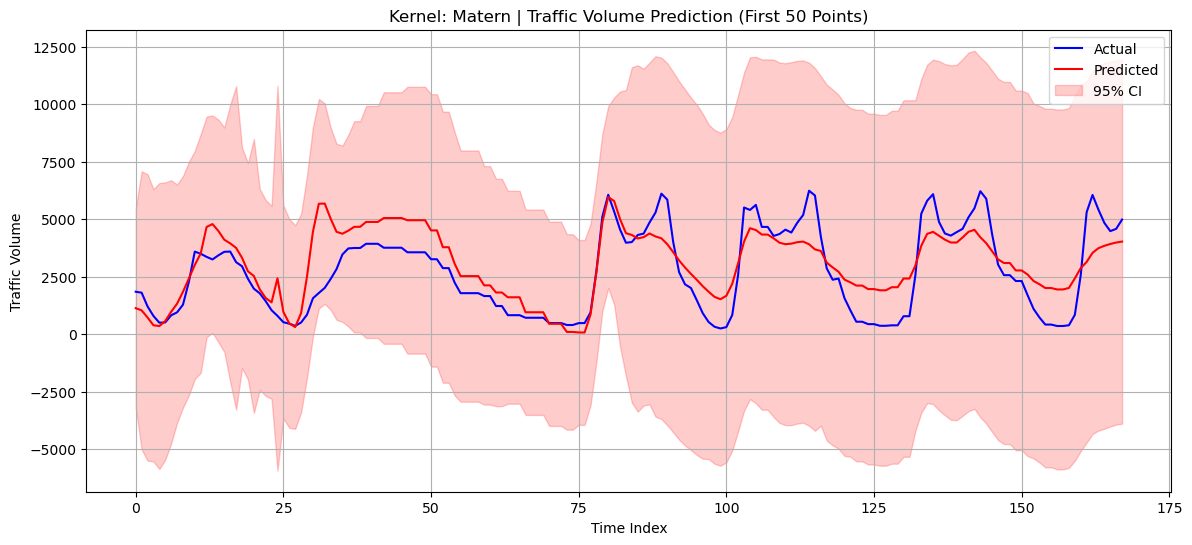


Kernel: Periodic
Test RMSE: 1157.82


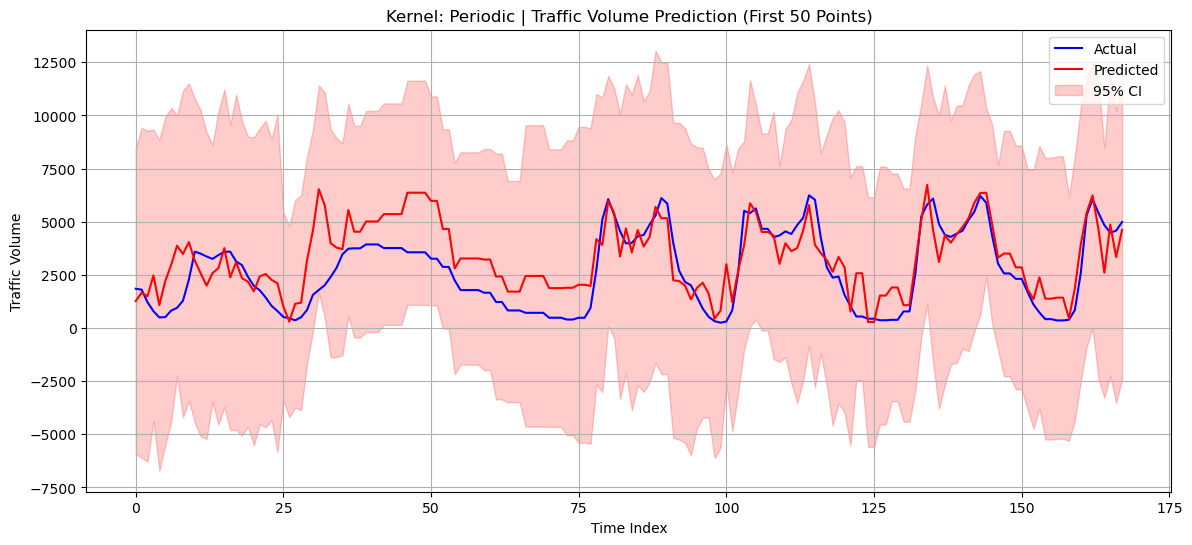

In [4]:
# Final Test Evaluation and Plot for each kernel
for name, res in results.items():
    model = res["model"]
    likelihood = res["likelihood"]
    
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(X_test_tensor))
        mean = test_pred.mean.numpy()
        std = test_pred.stddev.numpy()
        mean_inv = y_scaler.inverse_transform(mean.reshape(-1, 1)).flatten()
        y_true = y_scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()
        std_inv = std * (y_scaler.data_max_ - y_scaler.data_min_)
        rmse = np.sqrt(np.mean((mean_inv - y_true) ** 2))

    print(f"\nKernel: {name}")
    print(f"Test RMSE: {rmse:.2f}")

    # Plot
    plt.figure(figsize=(14, 6))

    n_len =24*7
    x_vals = np.arange(n_len)
    plt.plot(x_vals, y_true[:n_len], 'b-', label='Actual')
    plt.plot(x_vals, mean_inv[:n_len], 'r-', label='Predicted')
    plt.fill_between(x_vals,
                     mean_inv[:n_len] - 1.96 * std_inv[:n_len],
                     mean_inv[:n_len] + 1.96 * std_inv[:n_len],
                     color='r', alpha=0.2, label='95% CI')
    plt.legend()
    plt.title(f'Kernel: {name} | Traffic Volume Prediction (First 50 Points)')
    plt.xlabel('Time Index')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()
